# Read in the data

In [1]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

In [9]:
for col in combined.columns:
    print(col)

DBN
SCHOOL NAME
Num of SAT Test Takers
SAT Critical Reading Avg. Score
SAT Math Avg. Score
SAT Writing Avg. Score
sat_score
SchoolName
AP Test Takers 
Total Exams Taken
Number of Exams with scores 3 4 or 5
Demographic
School Name
Cohort
Total Cohort
Total Grads - n
Total Grads - % of cohort
Total Regents - n
Total Regents - % of cohort
Total Regents - % of grads
Advanced Regents - n
Advanced Regents - % of cohort
Advanced Regents - % of grads
Regents w/o Advanced - n
Regents w/o Advanced - % of cohort
Regents w/o Advanced - % of grads
Local - n
Local - % of cohort
Local - % of grads
Still Enrolled - n
Still Enrolled - % of cohort
Dropped Out - n
Dropped Out - % of cohort
CSD
NUMBER OF STUDENTS / SEATS FILLED
NUMBER OF SECTIONS
AVERAGE CLASS SIZE
SIZE OF SMALLEST CLASS
SIZE OF LARGEST CLASS
SCHOOLWIDE PUPIL-TEACHER RATIO
Name
schoolyear
fl_percent
frl_percent
total_enrollment
prek
k
grade1
grade2
grade3
grade4
grade5
grade6
grade7
grade8
grade9
grade10
grade11
grade12
ell_num
ell_percen

# Find correlations

In [10]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 67, dtype: float64


# Plotting survey correlations

In [11]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

In [12]:
%matplotlib inline
from matplotlib import pyplot as plt 


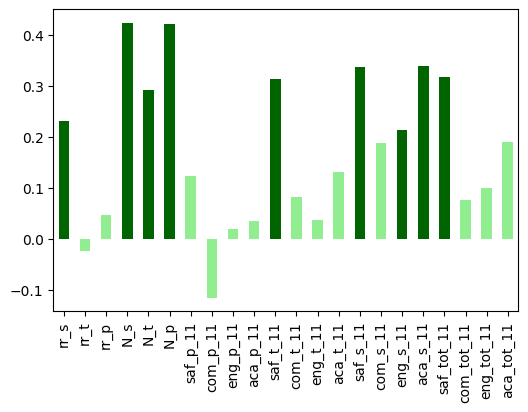

In [13]:
colors = ['darkgreen' if (x > 0.2) else 'lightgreen' for x in combined.corr()["sat_score"][survey_fields] ]
combined.corr()["sat_score"][survey_fields].plot.bar(color=colors)

There are higher correlations between N_s, N_t, N_p and sat_score, but none that goes above 0.5 not indicating a strong correlations. These columns are correlated with total_enrollment and so will be discarded from analysis.

The most ineresting in my POV is the relation between safety and sat_score as reflected in saf_t_11 and saf_s_11, even if weaker with saf_p_11.

The aca_s_11 (Academic expectations score based on student responses) correlates with sat_score, but this is not true for teachers aca_t_11 or parents aca_p_11 and that is an unexpected result.

Given the safety result, we will explore further the correlation with a scatter plot. 

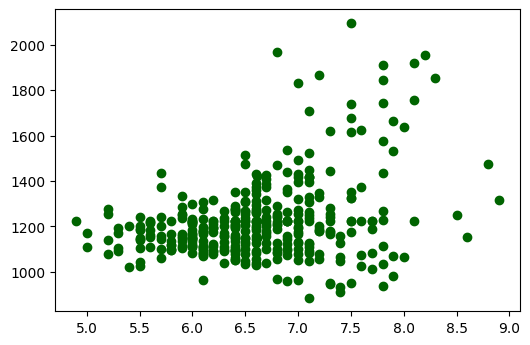

In [14]:
plt.scatter(x=combined["saf_s_11"], y=combined["sat_score"],color ='darkgreen')

The correlation is present, but not easy to identify. However, any school below 6.5 safety seems to be unable to score higher than 1600 in sat_scores. 

In [15]:
print (combined.groupby(['boro'])['saf_s_11'].mean())

boro
Bronx            6.606577
Brooklyn         6.370755
Manhattan        6.831370
Queens           6.721875
Staten Island    6.530000
Name: saf_s_11, dtype: float64


In [16]:
print (combined.groupby(['boro'])['sat_score'].mean())

boro
Bronx            1157.598203
Brooklyn         1181.364461
Manhattan        1278.331410
Queens           1286.753032
Staten Island    1382.500000
Name: sat_score, dtype: float64


It looks like Manhattan and Queens tend to have higher safety scores, whereas Brooklyn has low safety scores. However, when comparing with average sat_scores by borough, the correlation between safety and sat_scores is not so evident. 

In [17]:
combined_boro = combined.pivot_table(columns='boro', values = ('sat_score','saf_s_11'), fill_value=0)
print (combined_boro)

boro             Bronx     Brooklyn   Manhattan       Queens  Staten Island
saf_s_11      6.606577     6.370755     6.83137     6.721875           6.53
sat_score  1157.598203  1181.364461  1278.33141  1286.753032        1382.50


In [18]:
race_fields = ['white_per','asian_per','black_per','hispanic_per']


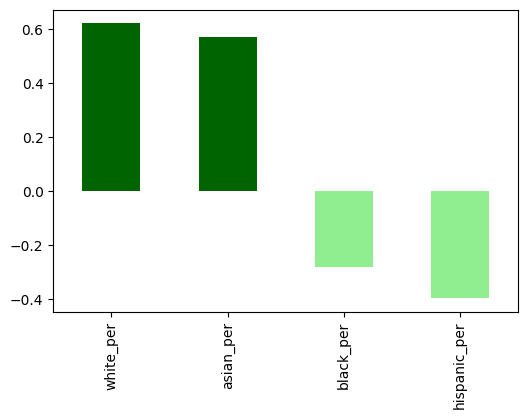

In [19]:
colors2 = ['darkgreen' if (x > 0.2) else 'lightgreen' for x in combined.corr()["sat_score"][race_fields] ]
combined.corr()["sat_score"][race_fields].plot.bar(color=colors2)

It looks like a higher percentage of white or asian students at a school correlates positively with sat score, whereas a higher percentage of black or hispanic students correlates negatively with sat score. 

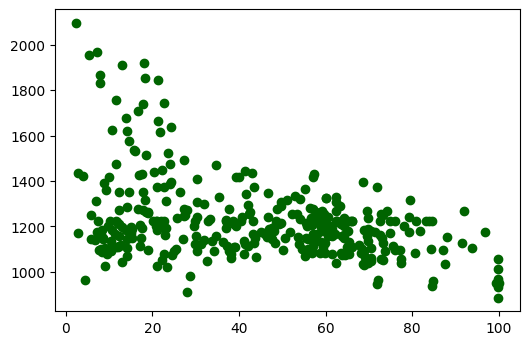

In [20]:
plt.scatter(x=combined["hispanic_per"], y=combined["sat_score"],color ='darkgreen')

A clear correlation between the percentage of hispanic population vs sat_score emerges, where no school with higher than 50% hispanic population scores higher than 1500, and schools with 100% seem to score below 1200. 

In [21]:
print (combined["SCHOOL NAME"].loc[combined["hispanic_per"]>95])

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


It seems that according to Wikipedia, these schools are part of Internationals Network for Public Schools that is an educational nonprofit supporting International high schools and academies, serving newly arrived immigrants who are English language learners (ELLs), in New York.

In [22]:
print (combined["SCHOOL NAME"].loc[(combined["hispanic_per"]<10) & (combined["sat_score"]>1800)])

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


It seems that admision to these schools involves passing the Specialized High Schools Admissions Test, so their students have higher academic credentials. However, it is unclear why a correlation between lower hispanic and higher sat score would result.

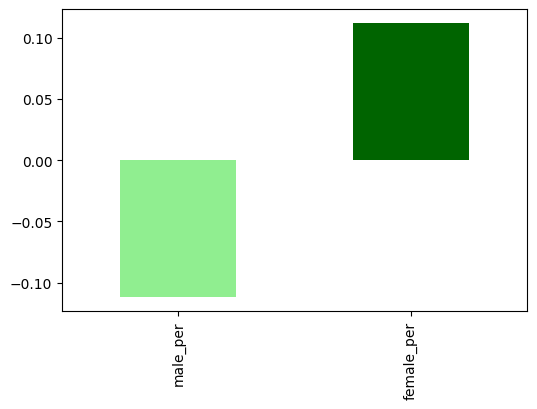

In [23]:
gender_fields = ['male_per','female_per']
colors3 = ['darkgreen' if (x > 0) else 'lightgreen' for x in combined.corr()["sat_score"][gender_fields] ]
combined.corr()["sat_score"][gender_fields].plot.bar(color=colors3)

There is no unexpected correlation on gender vs sat_score, as the correlation index for both columns is very weak. 

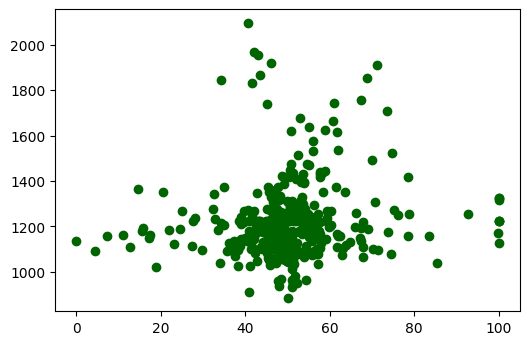

In [24]:
plt.scatter(x=combined["female_per"], y=combined["sat_score"], color ='darkgreen')

In [25]:
print (combined["SCHOOL NAME"].loc[(combined["female_per"]>60) & (combined["sat_score"]>1700)])

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


It seems from Wikipedia that these schools are selected over specialized high schools by students looking for a more liberal curriculum

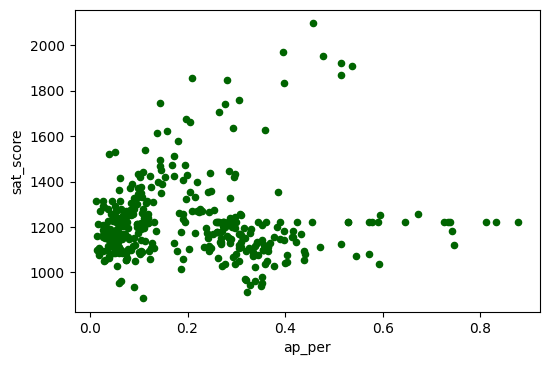

In [26]:
combined['ap_per'] = combined['AP Test Takers ']/combined['total_enrollment']
combined.plot.scatter(x='ap_per', y='sat_score',color ='darkgreen')

Not obvious to establish a relationship between sat_scores and the percentage of students that took AP tests. 

Determine whether there's a correlation between class size and SAT scores

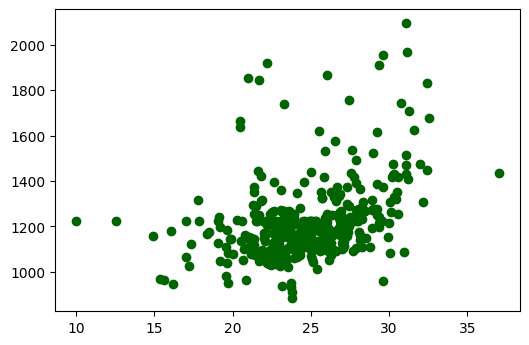

In [27]:
plt.scatter(x=combined["AVERAGE CLASS SIZE"], y=combined["sat_score"], color ='darkgreen')

In [28]:
combined_boro_class = combined.pivot_table(columns='boro', values = ('sat_score','AVERAGE CLASS SIZE'), fill_value=0)
print (combined_boro_class)

boro                      Bronx     Brooklyn    Manhattan       Queens  \
AVERAGE CLASS SIZE    23.894857    24.624036    24.605099    26.128505   
sat_score           1157.598203  1181.364461  1278.331410  1286.753032   

boro                Staten Island  
AVERAGE CLASS SIZE      28.119729  
sat_score             1382.500000  


There is no clear correlation between average class size and sat_scores. 

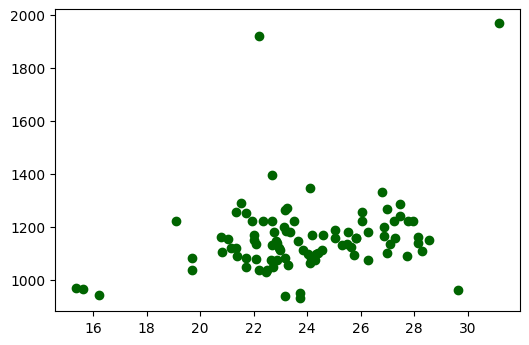

In [29]:
combined_bronx = combined.loc[combined['boro']=='Bronx']
plt.scatter(x=combined_bronx["AVERAGE CLASS SIZE"], y=combined_bronx["sat_score"], color ='darkgreen')

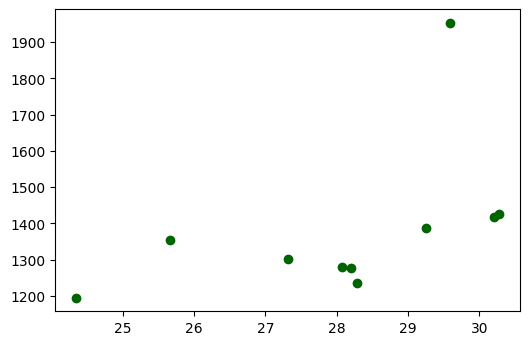

In [30]:
combined_staten = combined.loc[combined['boro']=='Staten Island']
plt.scatter(x=combined_staten["AVERAGE CLASS SIZE"], y=combined_staten["sat_score"], color ='darkgreen')

Neither in the boroughs with the highest average class size (Staten Island) nor in the one with lowest average class size (Bronx) seems to be a correlation with sat_scores. 